In [1]:
import numpy as np
import scipy.sparse as sp
from sklearn.datasets import load_svmlight_file
from oracle import Oracle, make_oracle
import scipy as sc
from methods import OptimizeLassoProximal, OptimizeGD, NesterovLineSearch
import matplotlib.pyplot as plt
from sklearn import linear_model

Решаем задачу логистической регрессии и l1-регуляризацией:
$$F(w) = - \frac{1}{N}\sum\limits_{i=1}^Ny_i\ln(\sigma_w(x_i)) + (1 - y_i)\ln(1 - \sigma_w(x_i)) + \lambda\|w\|_1,$$
где $\lambda$ -- параметр регуляризации.

Задачу решаем проксимальным градиентным методом. Убедимся сначала, что при $\lambda = 0$ наше решение совпадает с решением метода градиентного спуска с оценкой длины шага методом Нестерова.

In [2]:
orac = make_oracle('a1a.txt', penalty='l1', reg=0)
orac1 = make_oracle('a1a.txt')
x, y = load_svmlight_file('a1a.txt', zero_based=False)
m = x[0].shape[1] + 1
w0 = np.zeros((m, 1))
optimizer = OptimizeLassoProximal()
optimizer1 = OptimizeGD()
point = optimizer(orac, w0)
point1 = optimizer1(orac1, w0, NesterovLineSearch())

np.allclose(point, point1)

True

Изучим скорость сходимости метода на датасете a1a.txt ($\lambda = 0.001$)

In [3]:
def convergence_plot(xs, ys, xlabel, title=None):
    plt.figure(figsize = (12, 3))
    plt.xlabel(xlabel)
    plt.ylabel('F(w_{k+1} - F(w_k)')
    plt.plot(xs, ys)
    plt.yscale('log')
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    

In [4]:
orac = make_oracle('a1a.txt', penalty='l1', reg=0.001)
point = optimizer(orac, w0)

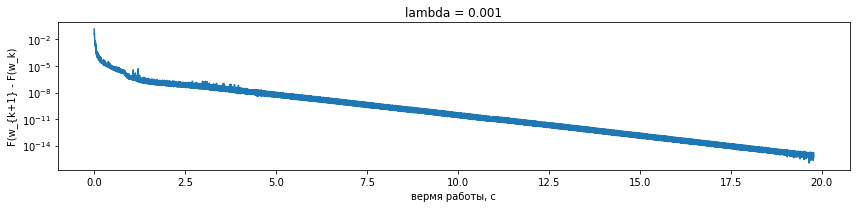

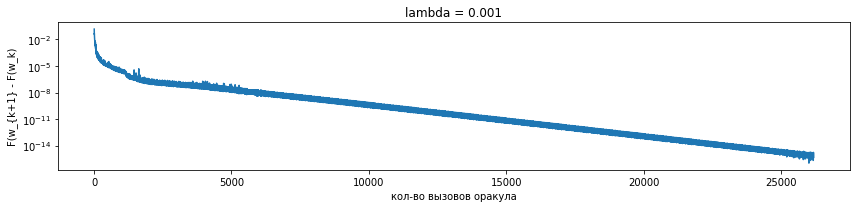

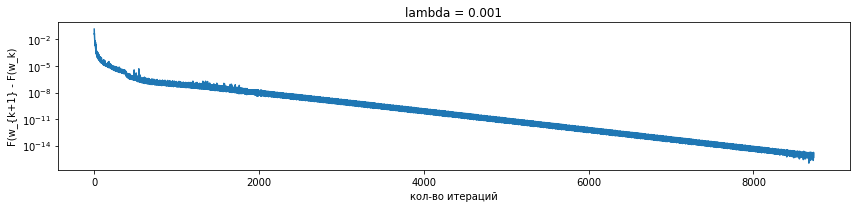

In [5]:
errs = optimizer.errs
title = 'lambda = 0.001'
convergence_plot(optimizer.times, errs, 'вермя работы, с', title)
convergence_plot(optimizer.orac_calls, errs, 'кол-во вызовов оракула', title)
convergence_plot(list(range(1, optimizer.n_iter + 1)), errs, 'кол-во итераций', title)

Заметим, что было использовано условие остановки $F(w_{k+1}) - F(w_k) \leq tol = 10^{-16}$. Из математических соображений кажется, что это ок, так как в вещественных числах сходимость последовательности равносильна её фундаментальности. Я также пытался использовать в качестве условия остановки $\|\nabla_w f(w_k)\|_2^2 / \|\nabla_w f(w_0)\|_2^2 <= tol$, где $f$ -- лосс логистической регрессии без регуляризации ($F = f + reg$), но, вообще говоря, не очень понятно, можно ли так делать, потому что оно учитывает только часть функции.

Из графиков видно, что метод обладает линейной скоростью сходимости

Изучим теперь зависимость скорости сходимости и количества ненулевых компонент в решении от параметра регуляризации $\lambda$

In [6]:
def plot(x, ys, ylabel, legend=False):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("lambda")
        plt.ylabel(ylabel)
        plt.plot(x, ys, 'o')
        plt.xscale('log')
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()

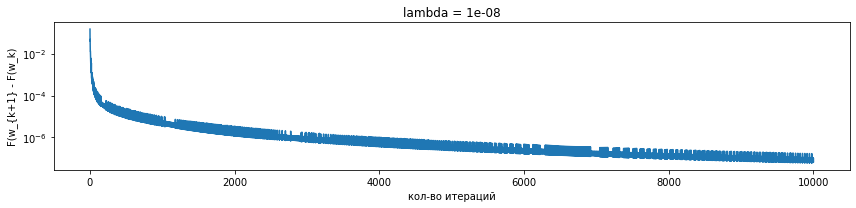

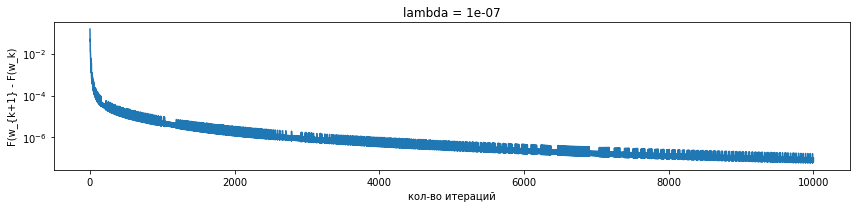

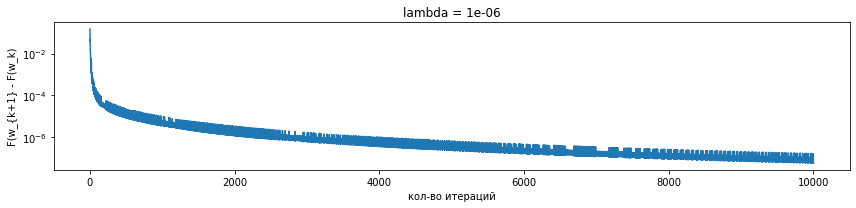

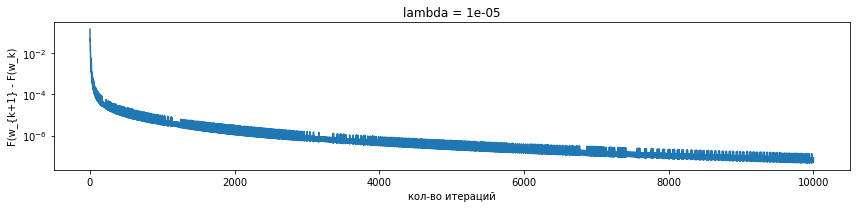

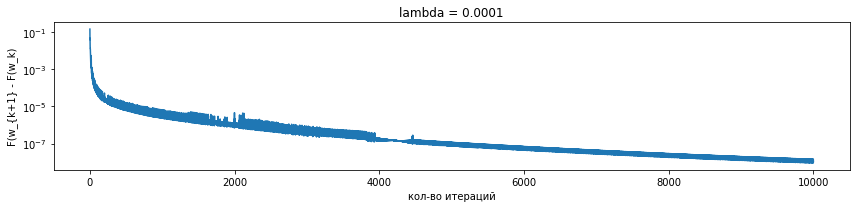

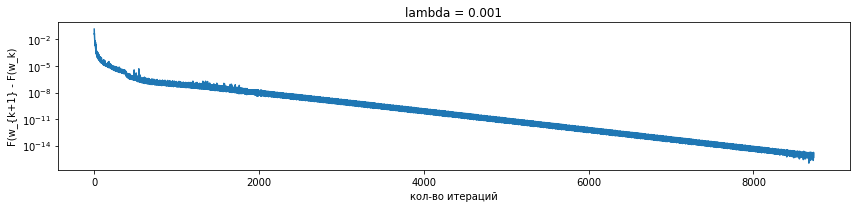

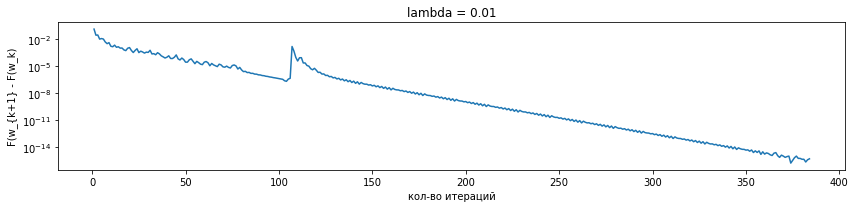

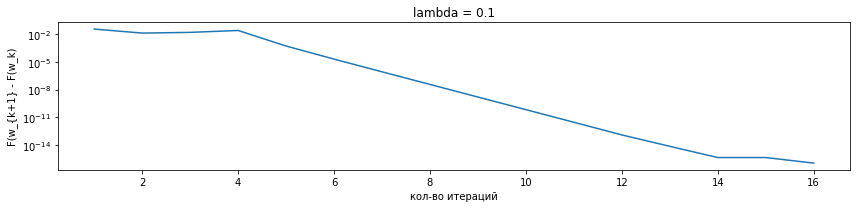

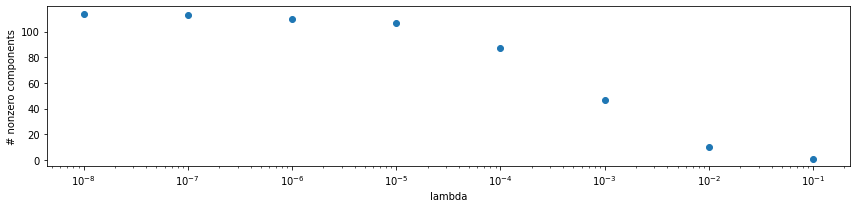

In [7]:
lambdas = [10**(-i) for i in range(8, 0, -1)]
non_zeros = []
for reg in lambdas:
    orac = make_oracle('a1a.txt', penalty='l1', reg=reg)
    point = optimizer(orac, w0)
    convergence_plot(list(range(1, optimizer.n_iter + 1)), optimizer.errs, 'кол-во итераций',
                    f"lambda = {reg}")
    non_zeros.append(len(np.nonzero(point)[0]))
plot(lambdas, non_zeros, '# nonzero components')

Видно, что параметр регуляризации практически не влияет на скорость сходимости (она всегда линейная), но количество итераций метода падает с увеличением параметра регуляризации. Так же из последнего графика делаем ожидаемый вывод, что число ненулевых компонент в решении уменьшается с ростом параметра регуляризации

Построим еще графики зависимости значения оптимизируемой функции и критерия остновки (ещё разок) в зависимости от итерации ($\lambda = 0.001$)

In [8]:
def value_plot(xs, ys, xlabel, title=None):
    plt.figure(figsize = (12, 3))
    plt.xlabel(xlabel)
    plt.ylabel('F(w_k)')
    plt.plot(xs, ys)
#     plt.yscale('log')
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

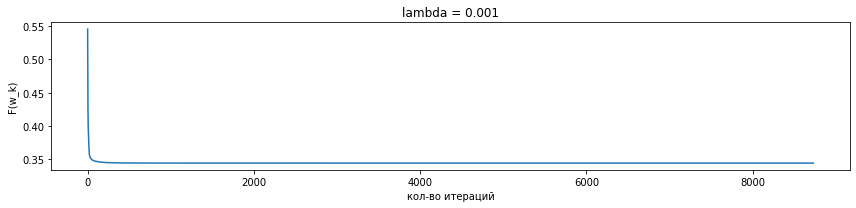

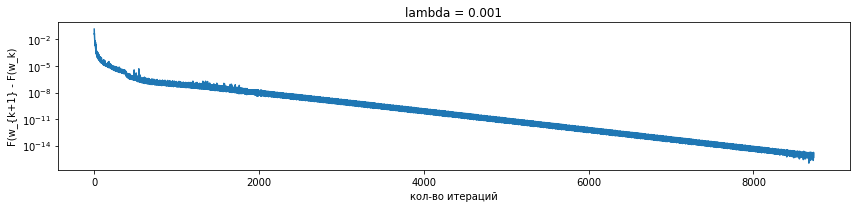

In [9]:
orac = make_oracle('a1a.txt', penalty='l1', reg=0.001)
point = optimizer(orac, w0)
title = 'lambda = 0.001'
value_plot(list(range(1, optimizer.n_iter + 1)), optimizer.values, 'кол-во итераций', title)
convergence_plot(list(range(1, optimizer.n_iter + 1)), optimizer.errs, 'кол-во итераций', title)

Для подтверждения сделаных выводов проверим их ещё на breast-cancer_scale датасете.

Проверка равносильности GD + Nesterov и Proximal + $\lambda = 0$:

In [10]:
orac = make_oracle('breast-cancer_scale.txt', penalty='l1', reg=0)
orac1 = make_oracle('breast-cancer_scale.txt')
x, y = load_svmlight_file('breast-cancer_scale.txt', zero_based=False)
m = x[0].shape[1] + 1
w0 = np.zeros((m, 1))
optimizer = OptimizeLassoProximal()
optimizer1 = OptimizeGD()
point = optimizer(orac, w0)
point1 = optimizer1(orac1, w0, NesterovLineSearch())

np.allclose(point, point1)

False

In [11]:
print(abs(orac.value(point) - orac1.value(point1)))

0.0001461093710795336


Сами вектора весов не совпали, но значения оптимизируемой функции близки, так что будем считать, что все ок.

Изучаем скорость сходимости для $\lambda = 0.001$:

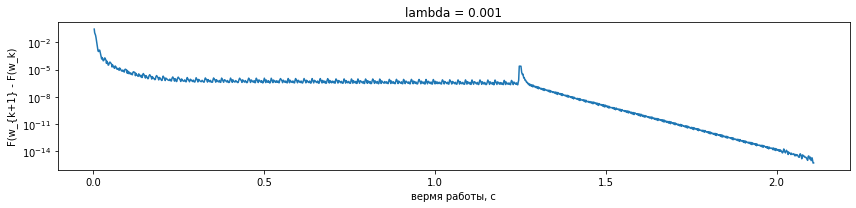

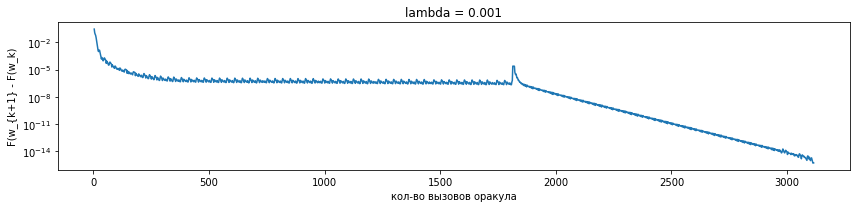

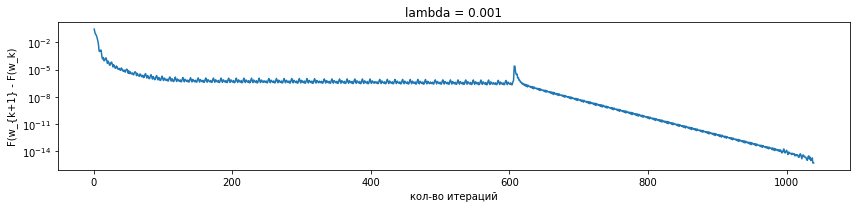

In [12]:
orac = make_oracle('breast-cancer_scale.txt', penalty='l1', reg=0.001)
point = optimizer(orac, w0)
errs = optimizer.errs
title = 'lambda = 0.001'
convergence_plot(optimizer.times, errs, 'вермя работы, с', title)
convergence_plot(optimizer.orac_calls, errs, 'кол-во вызовов оракула', title)
convergence_plot(list(range(1, optimizer.n_iter + 1)), errs, 'кол-во итераций', title)

Кажется, что скорость сходимости опять линейная

Изучаем зависимость скорости сходимости и количества ненулевых компонент в решении от $\lambda$

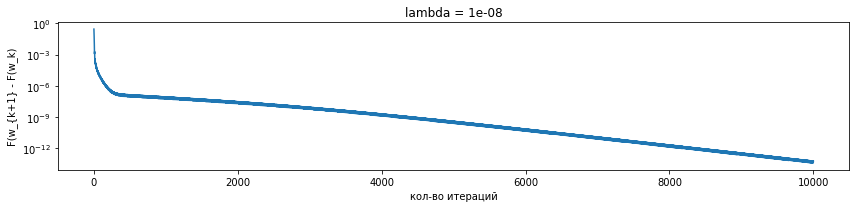

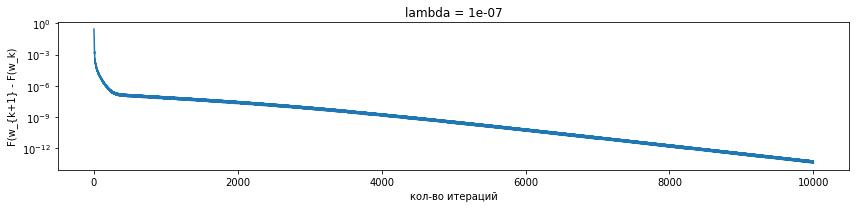

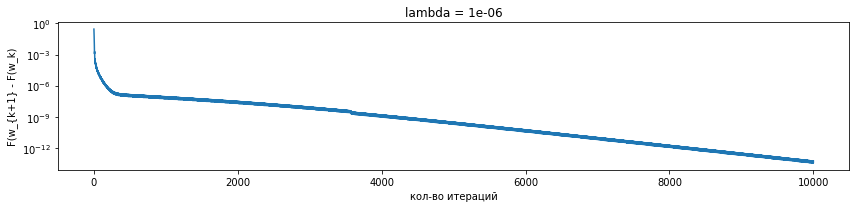

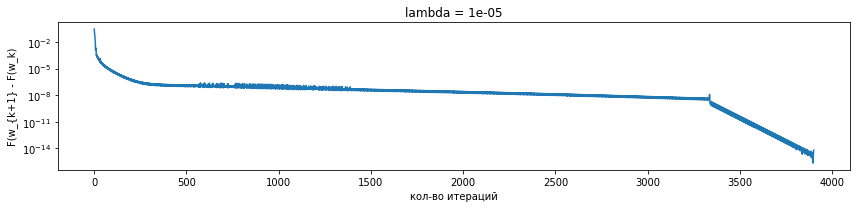

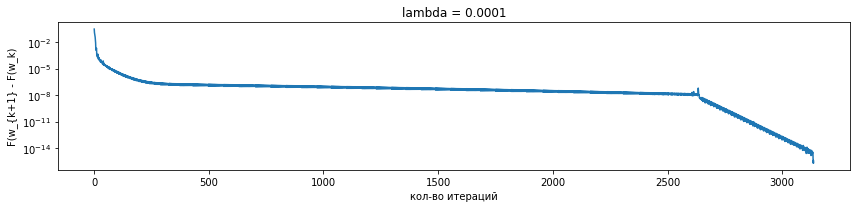

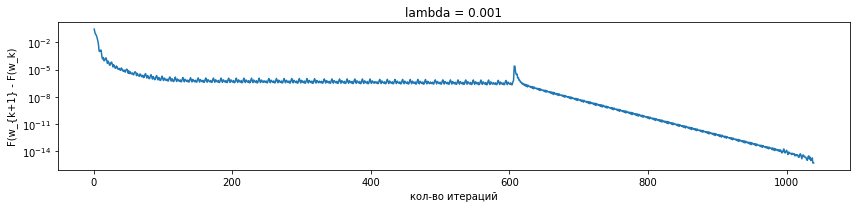

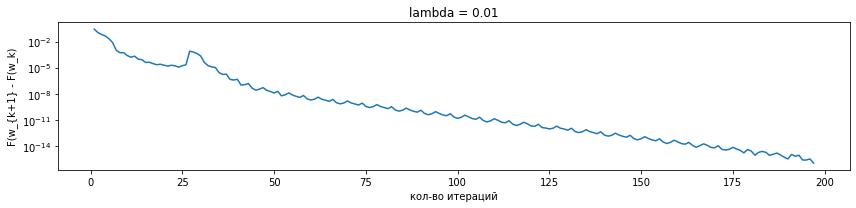

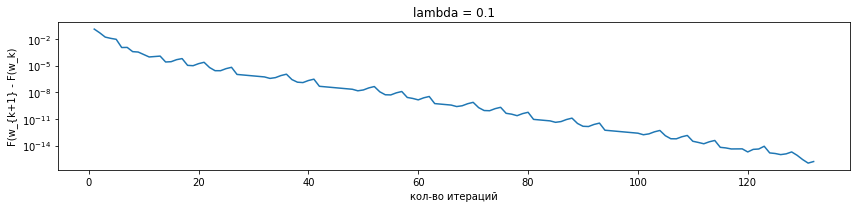

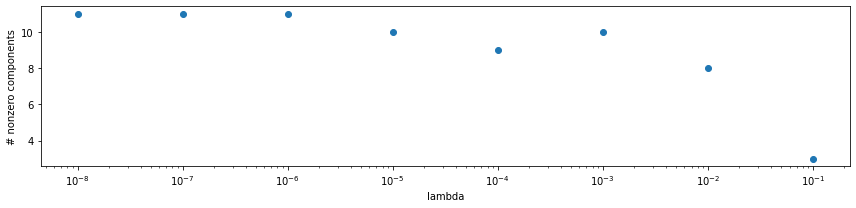

In [13]:
lambdas = [10**(-i) for i in range(8, 0, -1)]
non_zeros = []
for reg in lambdas:
    orac = make_oracle('breast-cancer_scale.txt', penalty='l1', reg=reg)
    point = optimizer(orac, w0)
    convergence_plot(list(range(1, optimizer.n_iter + 1)), optimizer.errs, 'кол-во итераций',
                    f"lambda = {reg}")
    non_zeros.append(len(np.nonzero(point)[0]))
plot(lambdas, non_zeros, '# nonzero components')

Делаем те же выводы

Построим напоследок грфики для значений оптимизируемой функции и критерия остановки (ещё разок) в зависимости от итерации ($\lambda = 0.001$)

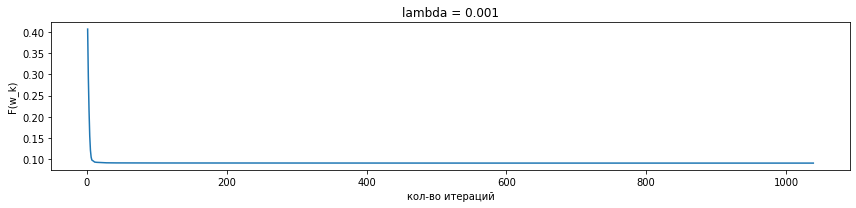

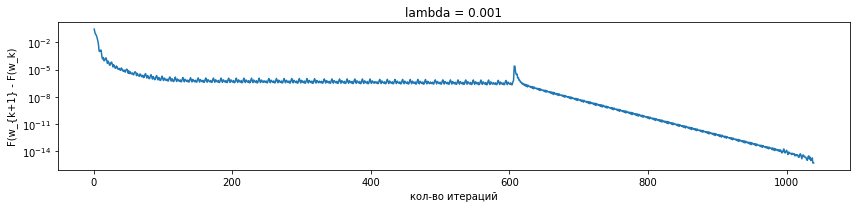

In [14]:
orac = make_oracle('breast-cancer_scale.txt', penalty='l1', reg=0.001)
point = optimizer(orac, w0)
title = 'lambda = 0.001'
value_plot(list(range(1, optimizer.n_iter + 1)), optimizer.values, 'кол-во итераций', title)
convergence_plot(list(range(1, optimizer.n_iter + 1)), optimizer.errs, 'кол-во итераций', title)

Конец.